In [15]:
import torch
import torch.utils.data
import matplotlib.pyplot as plt
%matplotlib notebook

import numpy as np
import sklearn.datasets

var = torch.autograd.Variable
ftn = torch.FloatTensor
ltn = torch.LongTensor

import collections

<IPython.core.display.Javascript object>


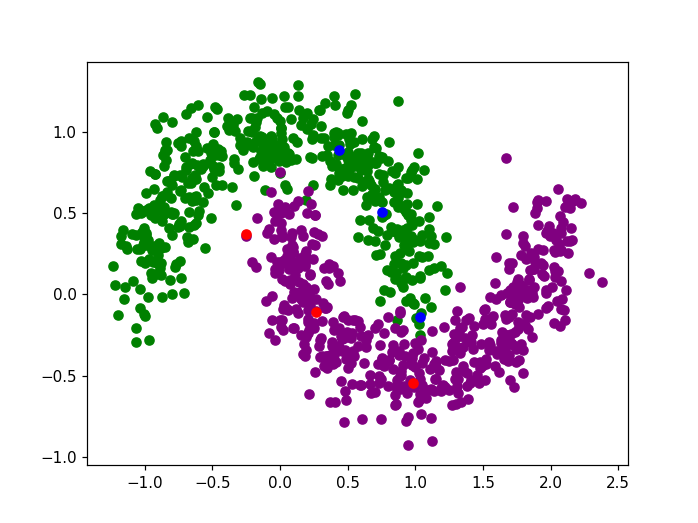

In [16]:
X_all, y_all = sklearn.datasets.make_moons(n_samples=1000, shuffle=False, noise=0.15, random_state=42)
X0_all = X_all[y_all == 0]
X1_all = X_all[y_all == 1]
i_labeled = 400

half_n_labeled = 3


Xu, yu = sklearn.datasets.make_moons(n_samples=1000, shuffle=False, noise=0.15, random_state=42)
X0u = Xu[yu == 0]
X1u = Xu[yu == 1]

Xl, yl = sklearn.datasets.make_moons(n_samples=4*half_n_labeled, shuffle=False, noise=0.15, random_state=43)
X0l = Xl[yl == 0][:half_n_labeled]
X1l = Xl[yl == 1][:half_n_labeled]

fig, ax = plt.subplots()
ax.scatter(X0u[:, 0], X0u[:, 1], c="green")
ax.scatter(X1u[:, 0], X1u[:, 1], c="purple")
ax.scatter(X0l[:, 0], X0l[:, 1], c="blue")
ax.scatter(X1l[:, 0], X1l[:, 1], c="red")


In [21]:
def _make_namer():
    tbl = dict()
    seen = set()
    def namer(name):
        if name in tbl:
            tbl[name] += 1
        else:
            tbl[name] = 0
        ret = f"{name}_{tbl[name]}"
        assert ret not in seen
        seen.add(ret)
        return ret
    return namer


def dkl(logp, logq):
    """D_KL(p || q) = ∑p×(log(p) - log(q))
    """
    logp = torch.nn.functional.log_softmax(logp, dim=1)
    logq = torch.nn.functional.log_softmax(logq, dim=1)
    p = torch.exp(logp)
    return (p*(logp - logq)).sum(dim=1, keepdim=True)
    # return torch.nn.functional.kl_div(torch.nn.functional.log_softmax(logq, dim=1), 
    #                                   torch.nn.functional.softmax(logp, dim=1),
    #                                   reduce=False).sum(dim=1)


def set_requires_grad(model, requires_grad):
    for p in model.parameters():
        p.requires_grad = requires_grad

        
def normalize(x):
    return x/x.norm(p=2, dim=1, keepdim=True)


def vat(model, X, xi, eps, Ip):
    assert xi > 0
    assert eps > 0
    set_requires_grad(model, False)

    y0 = model(var(X, volatile=True)).detach()
    y0.volatile = False
    d = normalize(torch.randn(X.shape))
    for i in range(Ip):
        r = var(xi*d, requires_grad=True)
        yr = model(var(X) + r)
        kl = dkl(y0, yr).mean()
        # As `r` is a new Variable, `r.backward()` is not necessary.
        kl.backward()
        d = normalize(r.grad.data)
    set_requires_grad(model, True)
    r_adv = var(eps*normalize(r.grad.data))
    yr_adv = model(var(X) + r_adv)
    return dkl(y0, yr_adv).mean()
    

namer = _make_namer()

n_in = 2
n_out = 2
n_middle = 100
model = torch.nn.Sequential(collections.OrderedDict([
    (namer("f"), torch.nn.Linear(n_in, n_middle)),
    (namer("a"), torch.nn.ReLU()),
    (namer("f"), torch.nn.Linear(n_middle, n_middle)),
    (namer("a"), torch.nn.ReLU()),
    (namer("f"), torch.nn.Linear(n_middle, n_middle)),
    (namer("a"), torch.nn.ReLU()),
    (namer("f"), torch.nn.Linear(n_middle, n_out)),
]))

def _init(m):
    if m == torch.nn.Linear:
        m.bias.data.zero_()
        torch.nn.init.kaiming_uniform(m.weight.data)
model.apply(_init)

Xl = var(ftn(np.concatenate((X0l, X1l))))
yl = var(ltn(([0]*half_n_labeled) + [1]*half_n_labeled))

opt = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
opt = torch.optim.Adam(model.parameters(), lr=1e-3, eps=1e-3)

200 0.22513655945658684 0.28428867
400 0.20198587328195572 0.24627967
600 0.27256472036242485 0.14490388
800 0.28929341584444046 0.15413988


<IPython.core.display.Javascript object>


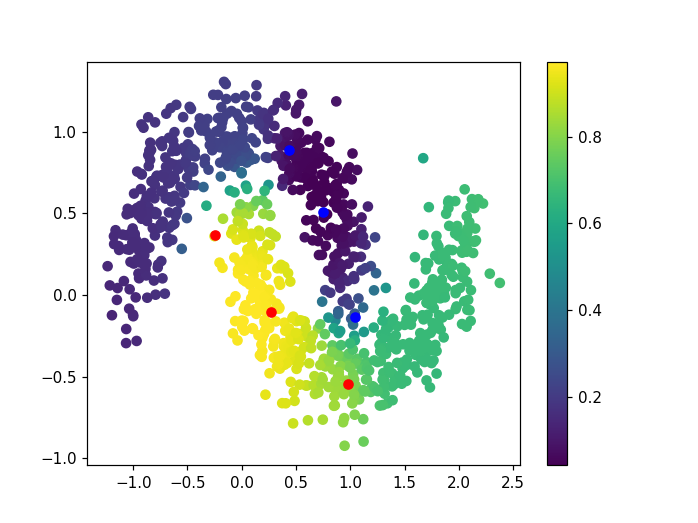

<IPython.core.display.Javascript object>


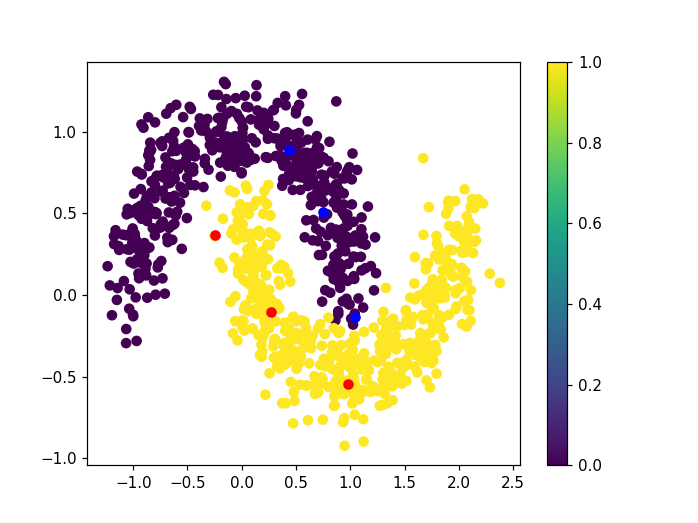

In [22]:
i_total_step = 0
eps = 1e-1
xi = 1e-3
gamma = 4e1
Ip = 2
dataset = torch.utils.data.TensorDataset(ftn(X_all), ltn(y_all))
for i_epoch in range(100):
    data_loader = torch.utils.data.DataLoader(dataset, 121, shuffle=True)
    for Xu, _ in data_loader:
        i_total_step += 1
        reg = vat(model=model, X=Xu, xi=xi, eps=eps, Ip=Ip)
        nll = torch.nn.functional.cross_entropy(model(Xl), yl)
        if i_total_step%200 == 0:
            print(i_total_step, gamma*reg.data.numpy()[0], nll.data.numpy()[0])
        loss = nll + gamma*reg
        #loss = nll - gamma*reg
        opt.zero_grad()
        loss.backward()
        opt.step()

fig, ax = plt.subplots()
z_pred = torch.nn.functional.softmax(model(var(ftn(X_all), volatile=True)), dim=1).data.numpy()[:, 1]
h = ax.scatter(X_all[:, 0], X_all[:, 1], c=z_pred, zorder=-1)
ax.scatter(X0l[:, 0], X0l[:, 1], c="blue", zorder=1)
ax.scatter(X1l[:, 0], X1l[:, 1], c="red", zorder=1)
fig.colorbar(h)

fig, ax = plt.subplots()
z_pred = torch.nn.functional.softmax(model(var(ftn(X_all), volatile=True)), dim=1).data.numpy()[:, 1]
z_pred = np.where(z_pred > 0.5, 1, 0)
h = ax.scatter(X_all[:, 0], X_all[:, 1], c=z_pred, zorder=-1)
ax.scatter(X0l[:, 0], X0l[:, 1], c="blue", zorder=1)
ax.scatter(X1l[:, 0], X1l[:, 1], c="red", zorder=1)
fig.colorbar(h)